In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Sep 26 10:59:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mjp_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mjp_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mjp_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mjp_07July2020 import All_CNN6Layer_E as ModelE
from model.models_mjp_07July2020 import All_CNN6Layer_F as ModelF
from model.models_mjp_07July2020 import All_CNN6Layer_G as ModelG
from model.models_mjp_07July2020 import All_CNN6Layer_H as ModelH
from model.models_mjp_07July2020 import All_CNN6Layer_I as ModelI
from model.models_mjp_07July2020 import All_CNN6Layer_J as ModelJ
from model.models_mjp_07July2020 import All_CNN6Layer_K as ModelK
from model.models_mjp_07July2020 import All_CNN6Layer_L as ModelL
from model.models_mjp_07July2020 import All_CNN6Layer_M as ModelM
from model.models_mjp_07July2020 import All_CNN6Layer_N as ModelN

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 1420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.67 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.47 s
Constructing 160000 event dataset took 3.232 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.562 s
Constructing 9984 event dataset took 0.0851 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelG()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=1.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/f84b354fead64c8c9cdba4afac00a34f/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_G(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 12, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(12, 8, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(8, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


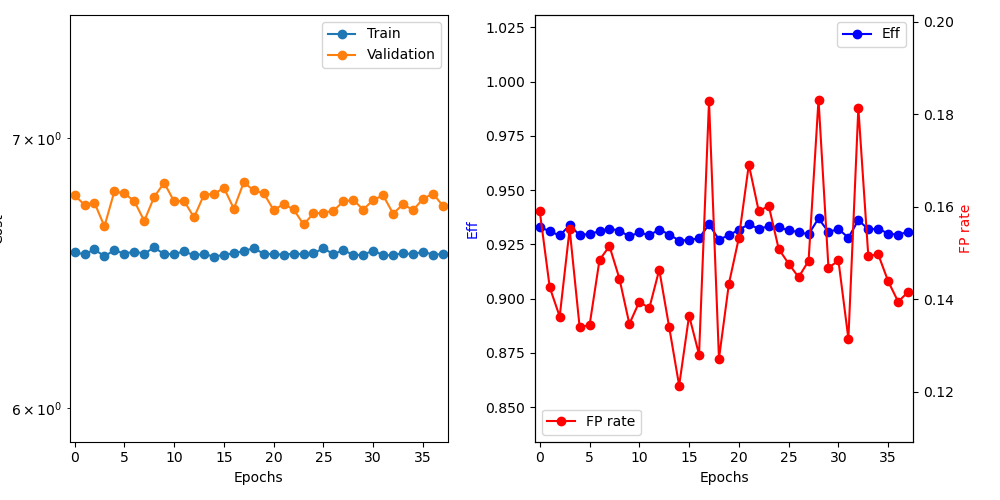

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
print('for model: ', model)   
run_name = 'ACNN G'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')
        mlflow.set_tag('Asymmetry', '1.5')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_G(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 12, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(12, 8, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(8, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 1420
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1420: train=6.55835, val=6.77456, took 30.222 s
  Validation Found 50854 of 54504, added 1588 (eff 93.30%) (0.159 FP/event)


Epoch 1421: train=6.55052, val=6.73786, took 29.861 s
  Validation Found 50744 of 54504, added 1424 (eff 93.10%) (0.143 FP/event)


Epoch 1422: train=6.5688, val=6.74614, took 29.778 s
  Validation Found 50640 of 54504, added 1361 (eff 92.91%) (0.136 FP/event)


Epoch 1423: train=6.54303, val=6.65563, took 30.062 s
  Validation Found 50896 of 54504, added 1550 (eff 93.38%) (0.155 FP/event)


Epoch 1424: train=6.56615, val=6.78984, took 30.115 s
  Validation Found 50654 of 54504, added 1339 (eff 92.94%) (0.134 FP/event)


Epoch 1425: train=6.55299, val=6.78187, took 30.132 s
  Validation Found 50676 of 54504, added 1342 (eff 92.98%) (0.134 FP/event)


Epoch 1426: train=6.5611, val=6.75236, took 30.173 s
  Validation Found 50748 of 54504, added 1483 (eff 93.11%) (0.149 FP/event)


Epoch 1427: train=6.55302, val=6.67634, took 30.132 s
  Validation Found 50814 of 54504, added 1513 (eff 93.23%) (0.152 FP/event)


Epoch 1428: train=6.57633, val=6.76836, took 30.142 s
  Validation Found 50760 of 54504, added 1443 (eff 93.13%) (0.145 FP/event)


Epoch 1429: train=6.551, val=6.82301, took 29.868 s
  Validation Found 50615 of 54504, added 1345 (eff 92.86%) (0.135 FP/event)


Epoch 1430: train=6.55143, val=6.75114, took 29.798 s
  Validation Found 50719 of 54504, added 1393 (eff 93.06%) (0.14 FP/event)


Epoch 1431: train=6.56155, val=6.75292, took 30.421 s
  Validation Found 50644 of 54504, added 1379 (eff 92.92%) (0.138 FP/event)


Epoch 1432: train=6.54667, val=6.68973, took 30.051 s
  Validation Found 50790 of 54504, added 1462 (eff 93.19%) (0.146 FP/event)


Epoch 1433: train=6.55242, val=6.77695, took 30.067 s
  Validation Found 50664 of 54504, added 1338 (eff 92.95%) (0.134 FP/event)


Epoch 1434: train=6.54141, val=6.7794, took 30.129 s
  Validation Found 50513 of 54504, added 1212 (eff 92.68%) (0.121 FP/event)


Epoch 1435: train=6.54916, val=6.80342, took 30.06 s
  Validation Found 50526 of 54504, added 1363 (eff 92.70%) (0.137 FP/event)


Epoch 1436: train=6.55439, val=6.72312, took 30.026 s
  Validation Found 50571 of 54504, added 1279 (eff 92.78%) (0.128 FP/event)


Epoch 1437: train=6.56285, val=6.82492, took 30.08 s
  Validation Found 50918 of 54504, added 1826 (eff 93.42%) (0.183 FP/event)


Epoch 1438: train=6.57373, val=6.79318, took 29.787 s
  Validation Found 50538 of 54504, added 1270 (eff 92.72%) (0.127 FP/event)


Epoch 1439: train=6.55258, val=6.78231, took 29.915 s
  Validation Found 50645 of 54504, added 1432 (eff 92.92%) (0.143 FP/event)


Epoch 1440: train=6.55094, val=6.71785, took 30.463 s
  Validation Found 50785 of 54504, added 1531 (eff 93.18%) (0.153 FP/event)


Epoch 1441: train=6.54947, val=6.74082, took 29.993 s
  Validation Found 50919 of 54504, added 1689 (eff 93.42%) (0.169 FP/event)


Epoch 1442: train=6.55282, val=6.72057, took 30.068 s
  Validation Found 50808 of 54504, added 1588 (eff 93.22%) (0.159 FP/event)


Epoch 1443: train=6.5513, val=6.66309, took 30.023 s
  Validation Found 50873 of 54504, added 1600 (eff 93.34%) (0.16 FP/event)


Epoch 1444: train=6.55375, val=6.70475, took 30.096 s
  Validation Found 50841 of 54504, added 1507 (eff 93.28%) (0.151 FP/event)


Epoch 1445: train=6.57349, val=6.70751, took 30.015 s
  Validation Found 50773 of 54504, added 1475 (eff 93.15%) (0.148 FP/event)


Epoch 1446: train=6.55039, val=6.71486, took 30.047 s
  Validation Found 50723 of 54504, added 1446 (eff 93.06%) (0.145 FP/event)


Epoch 1447: train=6.56705, val=6.75125, took 30.077 s
  Validation Found 50670 of 54504, added 1481 (eff 92.97%) (0.148 FP/event)


Epoch 1448: train=6.54749, val=6.7565, took 29.974 s
  Validation Found 51069 of 54504, added 1829 (eff 93.70%) (0.183 FP/event)


Epoch 1449: train=6.54921, val=6.71964, took 30.059 s
  Validation Found 50727 of 54504, added 1466 (eff 93.07%) (0.147 FP/event)


Epoch 1450: train=6.56433, val=6.75692, took 29.973 s
  Validation Found 50804 of 54504, added 1482 (eff 93.21%) (0.148 FP/event)


Epoch 1451: train=6.54727, val=6.77421, took 30.011 s
  Validation Found 50584 of 54504, added 1313 (eff 92.81%) (0.131 FP/event)


Epoch 1452: train=6.54728, val=6.70392, took 30.005 s
  Validation Found 51025 of 54504, added 1811 (eff 93.62%) (0.181 FP/event)


Epoch 1453: train=6.55529, val=6.74042, took 30.069 s
  Validation Found 50796 of 54504, added 1492 (eff 93.20%) (0.149 FP/event)


Epoch 1454: train=6.55033, val=6.71744, took 29.865 s
  Validation Found 50808 of 54504, added 1495 (eff 93.22%) (0.15 FP/event)


Epoch 1455: train=6.56077, val=6.76082, took 30.101 s
  Validation Found 50689 of 54504, added 1437 (eff 93.00%) (0.144 FP/event)


Epoch 1456: train=6.54922, val=6.781, took 30.055 s
  Validation Found 50657 of 54504, added 1393 (eff 92.94%) (0.14 FP/event)


Epoch 1457: train=6.5517, val=6.73438, took 30.021 s
  Validation Found 50736 of 54504, added 1414 (eff 93.09%) (0.142 FP/event)


In [ ]:
##quit()